In [1]:
try:
    %reload_ext lab_black
    %matplotlib inline
except Exception as e:
    print(e)

import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("./multiTimeline.csv", header=1, index_col=0)
df

,covid: (Worldwide)
Day,
2020-03-01,5
2020-03-02,7
2020-03-03,7
2020-03-04,8
2020-03-05,9
...,...
2020-09-01,50
2020-09-02,51
2020-09-03,51


In [3]:
df = df.rename(columns={df.columns[0]: "y"})

In [4]:
def shift_data(data, offset):
    df = data.copy(deep=True)
    for i in range(offset):
        df.insert(len(df.columns), f"x{i+1}", df.iloc[:, -1].shift(1, fill_value=0))
    return df.iloc[offset:]

In [5]:
shift_offset = 3
shifted_df = shift_data(df, shift_offset)
shifted_df

,y,x1,x2,x3
Day,,,,
2020-03-04,8,7,7,5
2020-03-05,9,8,7,7
2020-03-06,11,9,8,7
2020-03-07,11,11,9,8
2020-03-08,12,11,11,9
...,...,...,...,...
2020-09-01,50,53,46,46
2020-09-02,51,50,53,46
2020-09-03,51,51,50,53


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    shifted_df.iloc[:, 1:], shifted_df["y"], test_size=0.2, shuffle=False
)
X_train.info(), X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, 2020-03-04 to 2020-07-29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x1      148 non-null    int64
 1   x2      148 non-null    int64
 2   x3      148 non-null    int64
dtypes: int64(3)
memory usage: 4.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 2020-07-30 to 2020-09-05
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x1      38 non-null     int64
 1   x2      38 non-null     int64
 2   x3      38 non-null     int64
dtypes: int64(3)
memory usage: 1.2+ KB


(None, None)

In [7]:
def build_model(input_dim):
    input_layer = keras.layers.Input(shape=(input_dim,))

    attention_probs = keras.layers.Dense(input_dim, activation="softmax")(input_layer)
    attention_mul = keras.layers.multiply([input_layer, attention_probs])

    fc_attention_mul = keras.layers.Dense(64)(attention_mul)
    y = keras.layers.Dense(1, activation="sigmoid")(fc_attention_mul)

    return keras.Model(inputs=[input_layer], outputs=y)

In [8]:
model = build_model(shift_offset)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 3)            12          input_1[0][0]                    
__________________________________________________________________________________________________
multiply (Multiply)             (None, 3)            0           input_1[0][0]                    
                                                                 dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           256         multiply[0][0]        

In [9]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=100, verbose=0)

In [10]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

output_data = activation_model.predict(X_test)
len(output_data)

5

In [11]:
attention_vector = np.mean(output_data[1], axis=0)
attention_vector

array([8.257435e-38, 6.741016e-27, 1.000000e+00], dtype=float32)

<AxesSubplot:>

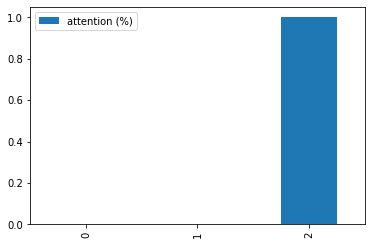

In [12]:
df = pd.DataFrame(attention_vector.transpose(), columns=["attention (%)"])
df.plot.bar()